# Training d'un agent Othello

## Importation des modules

In [1]:
from Board import Board, Signal, game_over_from_signal
from Agent import Memory, Model, encode_action

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from IPython.display import display # to display images

import math
import random
import numpy as np

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Définition d'un mmodèle de réseau de neurones

In [2]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        # Input (2, 8, 8,)
        # Output (65,)
        self.input_layer = nn.Linear(128, 128)
        self.hidden_layer_1 = nn.Linear(128, 128)
        self.hidden_layer_2 = nn.Linear(128, 128)
        self.hidden_layer_3 = nn.Linear(128, 128)
        self.hidden_layer_4 = nn.Linear(128, 128)
        self.hidden_layer_5 = nn.Linear(128, 128)
        # self.hidden_layer_6 = nn.Linear(128, 128)
        # self.hidden_layer_7 = nn.Linear(128, 128)
        # self.hidden_layer_8 = nn.Linear(128, 128)
        # self.hidden_layer_9 = nn.Linear(128, 128)
        # self.hidden_layer_10 = nn.Linear(128, 128)
        # self.hidden_layer_11 = nn.Linear(128, 128)
        # self.input_layer = nn.Conv2d(2, 128, 3, padding=1)
        # self.hidden_layer_1 = nn.Conv2d(128, 128, 3, padding=1)
        # self.hidden_layer_2 = nn.Conv2d(128, 128, 3, padding=1)
        # self.hidden_layer_3 = nn.Conv2d(128, 128, 3, padding=1)
        # self.hidden_layer_4 = nn.Conv2d(128, 128, 3, padding=1)
        # self.hidden_layer_5 = nn.Linear(128*8*8, 128*8)
        # self.hidden_layer_6 = nn.Linear(128*8, 128)
        self.output_layer = nn.Linear(128, 65)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer_1(x))
        x = F.relu(self.hidden_layer_2(x))
        x = F.relu(self.hidden_layer_3(x))
        x = F.relu(self.hidden_layer_4(x))
        x = F.relu(self.hidden_layer_5(x))
        # x = F.relu(self.hidden_layer_6(x))
        # x = F.relu(self.hidden_layer_7(x))
        # x = F.relu(self.hidden_layer_8(x))
        # x = F.relu(self.hidden_layer_9(x))
        # x = F.relu(self.hidden_layer_10(x))
        # x = F.relu(self.hidden_layer_11(x))
        output = self.output_layer(x)
        return output
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [3]:
def reward_from_signal(signal: Signal, board: Board):
    reward = 0
    if signal is Signal.ILLEGAL_MOVE:
            reward = -1
    elif signal is Signal.VALID_MOVE:
        reward = 1
    else: # Game over
        winner = board.get_winner()
        if winner == 1: # White
            reward = 100
        elif winner == -1: # Black
            reward = -100
        else: # Draw
            reward = -50
    return reward

def game_over_from_signal(signal: Signal, board: Board):
    game_over = signal in [Signal.GAME_OVER, Signal.ILLEGAL_MOVE]
    return game_over

## Méthode de visualisation des q_matrix

In [4]:
def render_q(q: list):
    dimension = (128, 128)
    max_negative = np.min([np.min(q), 0])
    max_positive = np.max([np.max(q), 0])
    image = Image.new('RGBA', dimension, (255,255,225,255))
    draw = ImageDraw.Draw(image)
    y = 0
    i = 0
    for l in range(8):
        x = 0
        for c in range(8):
            xy = [(x + 1, y + 1), (x + 14, y + 14)]
            r = q[i]
            if r > 0:
                # a = min(255, max(0, int(r * 1 * 255)))
                a = int(r / max_positive * 255)
                color = (0,0,255,a)
                draw.rectangle(xy, fill=color)
            elif r < 0:
                # a = min(255, max(0, int(-r * 1 * 255)))
                a = int(r / max_negative * 255)
                color = (255,0,0,a)
                draw.rectangle(xy, fill=color)
            x += 16
            i += 1
        y += 16
    display(image)

## Premiere étape : apprentissage d'un seul coup

Q_matrix of initial state, before training:


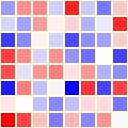

Target Q matrix:


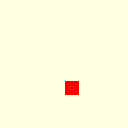

Q_matrix of initial state, after training:


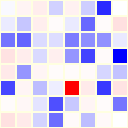

In [106]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Get initial state from the board
initial_s, signal = board.reset()
initial_s = torch.tensor(initial_s, dtype=torch.float).unsqueeze(0)

# Predict an action
a_scores = model(initial_s)
a = torch.argmax(a_scores).item()
encoded_a = encode_action(a)

# Perform the action in the game
s, signal = board.step(encoded_a)
next_s = torch.tensor(s, dtype=torch.float).unsqueeze(0)

# Process the signal
r = reward_from_signal(signal, board)
done = game_over_from_signal(signal, board)

# Q Learning
target_q = torch.zeros((65,), dtype=torch.float)

# Add the reward and action
target_q[a] = r

# Render model before the training
print("Q_matrix of initial state, before training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

# Toggle on train mode
model.train()

for i in range(16):
    # Compute loss on the difference between model output and target_q
    q_pred = model(torch.tensor(initial_s, dtype=torch.float))
    loss = criterion(torch.tensor(target_q, dtype=torch.float), q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Target Q matrix:")
render_q(target_q.tolist())

# Render model after the training
print("Q_matrix of initial state, after training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

## Deuxième étape : apprentissage du premier état avec historique

Q_matrix of initial state, before training:


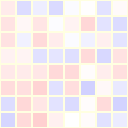

Target Q matrix:


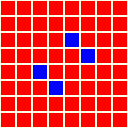

Q_matrix of initial state, after training:


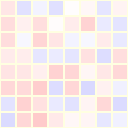

In [18]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Render model before the training
print("Q_matrix of initial state, before training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

# (Action, Reward) container for each action
history = []

# Populating the history with every possible move
for i_action in range(65):
    # Reset the board
    board.reset()

    # Predict an action
    a = i_action
    encoded_a = encode_action(a)

    # Perform the action in the game
    s, signal = board.step(encoded_a)

    # Process the signal
    r = reward_from_signal(signal, board)

    # Add the record to history
    history.append((a, r))

# Q Learning matrix for the initial state
target_q = torch.zeros((65,), dtype=torch.float)

# Add the reward and action for each game in history
# NOTE: ça overwrite si y'a plusieurs valeurs
for (a, r) in history:
    target_q[a] = r

print("Target Q matrix:")
render_q(target_q.tolist())

# Toggle on train mode
model.train()

for i_batch in range(1):
    # Compute loss on the difference between model output and target_q
    q_pred = model(torch.tensor(initial_s, dtype=torch.float))
    loss = criterion(torch.tensor(target_q, dtype=torch.float), q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Render model after the training
print(f"Q_matrix of initial state, after training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

## Troisième étape : à combien de coup est-ce que l'agent "comprend" le premier état ?

Target Q matrix: step 1


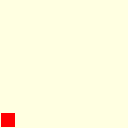

Q_matrix of initial state, after training: step 1


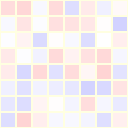

Target Q matrix: step 11


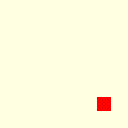

Q_matrix of initial state, after training: step 11


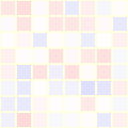

Target Q matrix: step 21


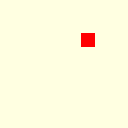

Q_matrix of initial state, after training: step 21


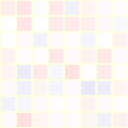

Target Q matrix: step 31


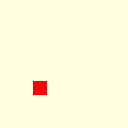

Q_matrix of initial state, after training: step 31


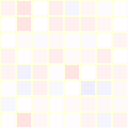

Target Q matrix: step 41


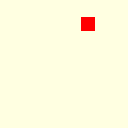

Q_matrix of initial state, after training: step 41


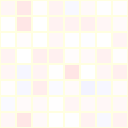

Target Q matrix: step 51


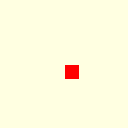

Q_matrix of initial state, after training: step 51


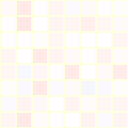

Target Q matrix: step 61


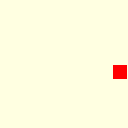

Q_matrix of initial state, after training: step 61


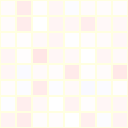

Target Q matrix: step 71


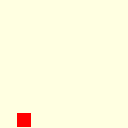

Q_matrix of initial state, after training: step 71


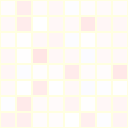

Target Q matrix: step 81


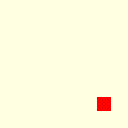

Q_matrix of initial state, after training: step 81


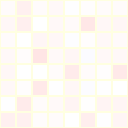

Target Q matrix: step 91


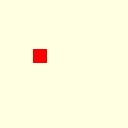

Q_matrix of initial state, after training: step 91


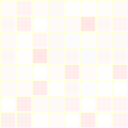

Target Q matrix: step 101


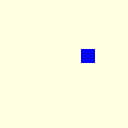

Q_matrix of initial state, after training: step 101


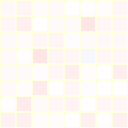

Target Q matrix: step 111


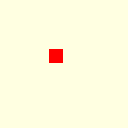

Q_matrix of initial state, after training: step 111


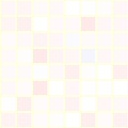

Target Q matrix: step 121


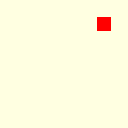

Q_matrix of initial state, after training: step 121


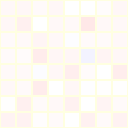

Target Q matrix: step 131


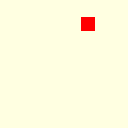

Q_matrix of initial state, after training: step 131


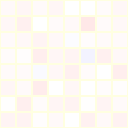

Target Q matrix: step 141


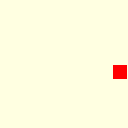

Q_matrix of initial state, after training: step 141


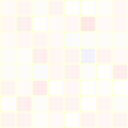

Target Q matrix: step 151


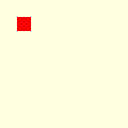

Q_matrix of initial state, after training: step 151


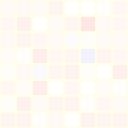

Target Q matrix: step 161


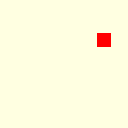

Q_matrix of initial state, after training: step 161


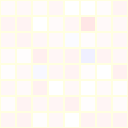

Target Q matrix: step 171


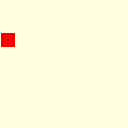

Q_matrix of initial state, after training: step 171


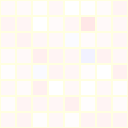

Target Q matrix: step 181


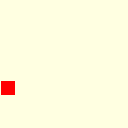

Q_matrix of initial state, after training: step 181


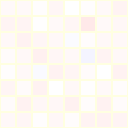

Target Q matrix: step 191


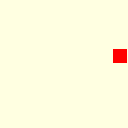

Q_matrix of initial state, after training: step 191


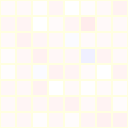

Target Q matrix: step 201


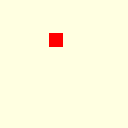

Q_matrix of initial state, after training: step 201


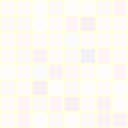

Target Q matrix: step 211


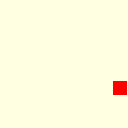

Q_matrix of initial state, after training: step 211


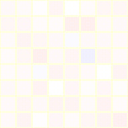

Target Q matrix: step 221


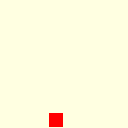

Q_matrix of initial state, after training: step 221


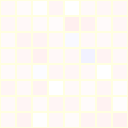

In [19]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
batch_size = 32
n_epochs = 256 # On aura pas joué tous les coups mais OK
max_history = 64
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# (Action, Reward) container for each action
history = []

# Populating the history with every possible move
for i_epoch in range(n_epochs):
    # Reset the board
    initial_s, _ = board.reset()
    initial_s = torch.tensor(initial_s, dtype=torch.float).unsqueeze(0)

    # Play a random action
    a = torch.randint(0, 65, (1,)).item()
    encoded_a = encode_action(a)

    # Perform the action in the game
    s, signal = board.step(encoded_a)

    # Process the signal
    r = reward_from_signal(signal, board)

    # Add the record to history
    history.append((a, r))

    # Continue playing if we don't have enough moves to learn in the history
    if len(history) <= batch_size:
        continue

    # Keep history the wanted size removing first element in list
        if len(history) > max_history:
            history.pop(0)

    # Add the reward and action for each game in history
    # NOTE: ça overwrite si y'a plusieurs valeurs, donc batch_size devrait être < 65
    # TODO: moyenne des valeurs ? pas d'overwrite ?
    targets = torch.zeros(batch_size, 65)
    inputs = torch.zeros(batch_size, 2, 8, 8)
    for i_batch, (a, r) in enumerate(random.sample(history, batch_size)):
        # Q Learning matrix for the initial state
        # NOTE: Je pense qu'il faudrait partir de la prédiction du modèle
        # et y ajouter les rewards, les cases où il y a 0 peuvent peut-être
        # poser problème
        target_q = torch.zeros((65,), dtype=torch.float)#model(initial_s).view(-1)# torch.zeros((65,), dtype=torch.float)
        target_q[a] = r
        targets[i_batch] = target_q
        inputs[i_batch] = initial_s

    # Toggle on train mode
    model.train()

    # for i_batch in range(4):
    # Compute loss on the difference between model output and target_q
    inputs = torch.tensor(inputs)
    targets = torch.tensor(targets)
    q_pred = model(inputs)        
    q_pred = torch.clip(q_pred, -3, 3)
    loss = criterion(targets, q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i_epoch - batch_size) % 10 == 0:
        print(f"Target Q matrix: step {i_epoch - batch_size + 1}")
        render_q(target_q.tolist())

        print(f"Q_matrix of initial state, after training: step {i_epoch - batch_size + 1}")
        q_pred = model(torch.tensor(initial_s, dtype=torch.float))
        render_q(q_pred.tolist()[0])

## Etape 4 : mouvements futurs et epsilon

Epoch 0 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.9
Epoch 1 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 2 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 3 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 4 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 5 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 6 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 7 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 8 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 9 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 10 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 11 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 12 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.89
Epoch 13 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsilon 0.88
Epoch 14 	 reward: -0.5 	 length 1 	 mean_length 1.0 	 epsi

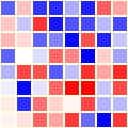

29


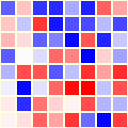

-------------


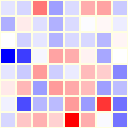

29
Epoch 66 	 reward: -0.5 	 length 1 	 mean_length 1.01 	 epsilon 0.84
Epoch 67 	 reward: -0.5 	 length 1 	 mean_length 1.02 	 epsilon 0.84
Epoch 68 	 reward: -0.5 	 length 1 	 mean_length 1.01 	 epsilon 0.84
Epoch 69 	 reward: -0.5 	 length 1 	 mean_length 1.02 	 epsilon 0.84
Epoch 70 	 reward: -0.5 	 length 1 	 mean_length 1.01 	 epsilon 0.84
Epoch 71 	 reward: -0.5 	 length 1 	 mean_length 1.02 	 epsilon 0.84
Epoch 72 	 reward: -0.5 	 length 1 	 mean_length 1.01 	 epsilon 0.84
Epoch 73 	 reward: -0.5 	 length 1 	 mean_length 1.02 	 epsilon 0.84
Epoch 74 	 reward: -0.5 	 length 1 	 mean_length 1.01 	 epsilon 0.84
Epoch 75 	 reward: -0.5 	 length 1 	 mean_length 1.02 	 epsilon 0.83
Epoch 76 	 reward: -0.5 	 length 1 	 mean_length 1.01 	 epsilon 0.83
Epoch 77 	 reward: -0.5 	 length 1 	 mean_length 1.02 	 epsilon 0.83
Epoch 78 	 reward: 1.5 	 length 2 	 mean_length 1.03 	 epsilon 0.83
Epoch 79 	 reward: -0.5 	 length 1 	 mean_length 1.04 	 epsilon 0.83
Epoch 80 	 reward: -0.5 	 length

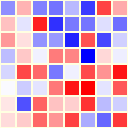

29


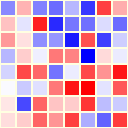

-------------


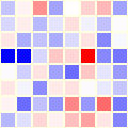

29
Epoch 166 	 reward: 1.5 	 length 2 	 mean_length 1.27 	 epsilon 0.77
Epoch 167 	 reward: 1.5 	 length 2 	 mean_length 1.28 	 epsilon 0.77
Epoch 168 	 reward: -0.5 	 length 1 	 mean_length 1.27 	 epsilon 0.77
Epoch 169 	 reward: -0.5 	 length 1 	 mean_length 1.28 	 epsilon 0.77
Epoch 170 	 reward: -0.5 	 length 1 	 mean_length 1.27 	 epsilon 0.76
Epoch 171 	 reward: -0.5 	 length 1 	 mean_length 1.28 	 epsilon 0.76
Epoch 172 	 reward: -0.5 	 length 1 	 mean_length 1.27 	 epsilon 0.76
Epoch 173 	 reward: -0.5 	 length 1 	 mean_length 1.28 	 epsilon 0.76
Epoch 174 	 reward: 1.5 	 length 2 	 mean_length 1.29 	 epsilon 0.76
Epoch 175 	 reward: -0.5 	 length 1 	 mean_length 1.3 	 epsilon 0.76
Epoch 176 	 reward: 1.5 	 length 2 	 mean_length 1.31 	 epsilon 0.76
Epoch 177 	 reward: -0.5 	 length 1 	 mean_length 1.32 	 epsilon 0.76
Epoch 178 	 reward: -0.5 	 length 1 	 mean_length 1.31 	 epsilon 0.76
Epoch 179 	 reward: 1.5 	 length 2 	 mean_length 1.3 	 epsilon 0.76
Epoch 180 	 reward: -0.5

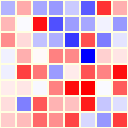

29


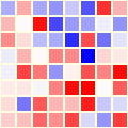

-------------


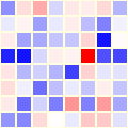

29
Epoch 266 	 reward: -0.5 	 length 1 	 mean_length 1.27 	 epsilon 0.7
Epoch 267 	 reward: -0.5 	 length 1 	 mean_length 1.26 	 epsilon 0.7
Epoch 268 	 reward: -0.5 	 length 1 	 mean_length 1.25 	 epsilon 0.7
Epoch 269 	 reward: 1.5 	 length 2 	 mean_length 1.26 	 epsilon 0.7
Epoch 270 	 reward: 1.5 	 length 2 	 mean_length 1.27 	 epsilon 0.7
Epoch 271 	 reward: -0.5 	 length 1 	 mean_length 1.28 	 epsilon 0.7
Epoch 272 	 reward: 1.5 	 length 2 	 mean_length 1.29 	 epsilon 0.7
Epoch 273 	 reward: 1.5 	 length 2 	 mean_length 1.3 	 epsilon 0.7
Epoch 274 	 reward: 1.5 	 length 2 	 mean_length 1.31 	 epsilon 0.7
Epoch 275 	 reward: -0.5 	 length 1 	 mean_length 1.3 	 epsilon 0.69
Epoch 276 	 reward: -0.5 	 length 1 	 mean_length 1.29 	 epsilon 0.69
Epoch 277 	 reward: -0.5 	 length 1 	 mean_length 1.28 	 epsilon 0.69
Epoch 278 	 reward: 1.5 	 length 2 	 mean_length 1.29 	 epsilon 0.69
Epoch 279 	 reward: -0.5 	 length 1 	 mean_length 1.3 	 epsilon 0.69
Epoch 280 	 reward: 1.5 	 length 2 

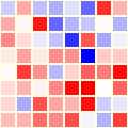

29


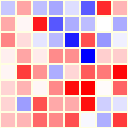

-------------


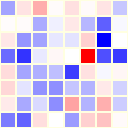

29
Epoch 366 	 reward: 1.5 	 length 2 	 mean_length 1.54 	 epsilon 0.64
Epoch 367 	 reward: 1.5 	 length 2 	 mean_length 1.56 	 epsilon 0.64
Epoch 368 	 reward: -0.5 	 length 1 	 mean_length 1.54 	 epsilon 0.64
Epoch 369 	 reward: -0.5 	 length 1 	 mean_length 1.56 	 epsilon 0.64
Epoch 370 	 reward: -0.5 	 length 1 	 mean_length 1.54 	 epsilon 0.64
Epoch 371 	 reward: -0.5 	 length 1 	 mean_length 1.54 	 epsilon 0.64
Epoch 372 	 reward: -0.5 	 length 1 	 mean_length 1.52 	 epsilon 0.64
Epoch 373 	 reward: 1.5 	 length 2 	 mean_length 1.52 	 epsilon 0.64
Epoch 374 	 reward: 4.0 	 length 3 	 mean_length 1.54 	 epsilon 0.63
Epoch 375 	 reward: 1.5 	 length 2 	 mean_length 1.54 	 epsilon 0.63
Epoch 376 	 reward: -0.5 	 length 1 	 mean_length 1.52 	 epsilon 0.63
Epoch 377 	 reward: -0.5 	 length 1 	 mean_length 1.54 	 epsilon 0.63
Epoch 378 	 reward: -0.5 	 length 1 	 mean_length 1.52 	 epsilon 0.63
Epoch 379 	 reward: 1.5 	 length 2 	 mean_length 1.52 	 epsilon 0.63
Epoch 380 	 reward: -0.

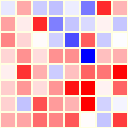

29


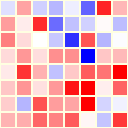

-------------


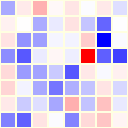

29
Epoch 466 	 reward: 1.5 	 length 2 	 mean_length 1.45 	 epsilon 0.58
Epoch 467 	 reward: -0.5 	 length 1 	 mean_length 1.44 	 epsilon 0.58
Epoch 468 	 reward: -0.5 	 length 1 	 mean_length 1.43 	 epsilon 0.58
Epoch 469 	 reward: 1.5 	 length 2 	 mean_length 1.44 	 epsilon 0.58
Epoch 470 	 reward: 1.5 	 length 2 	 mean_length 1.45 	 epsilon 0.58
Epoch 471 	 reward: 1.5 	 length 2 	 mean_length 1.46 	 epsilon 0.58
Epoch 472 	 reward: 1.5 	 length 2 	 mean_length 1.47 	 epsilon 0.58
Epoch 473 	 reward: -0.5 	 length 1 	 mean_length 1.48 	 epsilon 0.58
Epoch 474 	 reward: 1.5 	 length 2 	 mean_length 1.49 	 epsilon 0.58
Epoch 475 	 reward: -0.5 	 length 1 	 mean_length 1.46 	 epsilon 0.58
Epoch 476 	 reward: -0.5 	 length 1 	 mean_length 1.45 	 epsilon 0.58
Epoch 477 	 reward: 1.5 	 length 2 	 mean_length 1.46 	 epsilon 0.58
Epoch 478 	 reward: -0.5 	 length 1 	 mean_length 1.45 	 epsilon 0.58
Epoch 479 	 reward: -0.5 	 length 1 	 mean_length 1.46 	 epsilon 0.58
Epoch 480 	 reward: 1.5 

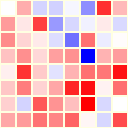

29


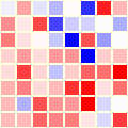

-------------


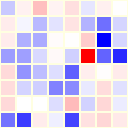

29
Epoch 566 	 reward: 1.5 	 length 2 	 mean_length 1.5 	 epsilon 0.53
Epoch 567 	 reward: 1.5 	 length 2 	 mean_length 1.5 	 epsilon 0.53
Epoch 568 	 reward: -0.5 	 length 1 	 mean_length 1.49 	 epsilon 0.53
Epoch 569 	 reward: -0.5 	 length 1 	 mean_length 1.5 	 epsilon 0.53
Epoch 570 	 reward: 1.5 	 length 2 	 mean_length 1.5 	 epsilon 0.53
Epoch 571 	 reward: 1.5 	 length 2 	 mean_length 1.5 	 epsilon 0.53
Epoch 572 	 reward: -0.5 	 length 1 	 mean_length 1.49 	 epsilon 0.53
Epoch 573 	 reward: -0.5 	 length 1 	 mean_length 1.48 	 epsilon 0.53
Epoch 574 	 reward: 1.5 	 length 2 	 mean_length 1.49 	 epsilon 0.53
Epoch 575 	 reward: -0.5 	 length 1 	 mean_length 1.48 	 epsilon 0.53
Epoch 576 	 reward: 1.5 	 length 2 	 mean_length 1.49 	 epsilon 0.53
Epoch 577 	 reward: 1.5 	 length 2 	 mean_length 1.5 	 epsilon 0.53
Epoch 578 	 reward: 1.5 	 length 2 	 mean_length 1.5 	 epsilon 0.53
Epoch 579 	 reward: 1.5 	 length 2 	 mean_length 1.52 	 epsilon 0.53
Epoch 580 	 reward: 1.5 	 length 

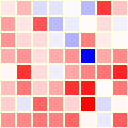

29


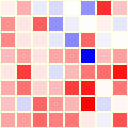

-------------


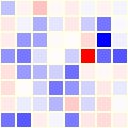

29
Epoch 666 	 reward: -0.5 	 length 1 	 mean_length 1.52 	 epsilon 0.49
Epoch 667 	 reward: 1.5 	 length 2 	 mean_length 1.52 	 epsilon 0.49
Epoch 668 	 reward: -0.5 	 length 1 	 mean_length 1.5 	 epsilon 0.49
Epoch 669 	 reward: 1.5 	 length 2 	 mean_length 1.52 	 epsilon 0.49
Epoch 670 	 reward: 1.5 	 length 2 	 mean_length 1.52 	 epsilon 0.49
Epoch 671 	 reward: 1.5 	 length 2 	 mean_length 1.52 	 epsilon 0.49
Epoch 672 	 reward: -0.5 	 length 1 	 mean_length 1.5 	 epsilon 0.49
Epoch 673 	 reward: -0.5 	 length 1 	 mean_length 1.52 	 epsilon 0.49
Epoch 674 	 reward: -0.5 	 length 1 	 mean_length 1.5 	 epsilon 0.49
Epoch 675 	 reward: -0.5 	 length 1 	 mean_length 1.5 	 epsilon 0.48
Epoch 676 	 reward: -0.5 	 length 1 	 mean_length 1.49 	 epsilon 0.48
Epoch 677 	 reward: 1.5 	 length 2 	 mean_length 1.48 	 epsilon 0.48
Epoch 678 	 reward: -0.5 	 length 1 	 mean_length 1.47 	 epsilon 0.48
Epoch 679 	 reward: -0.5 	 length 1 	 mean_length 1.46 	 epsilon 0.48
Epoch 680 	 reward: -0.5 	

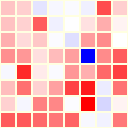

29


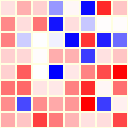

-------------


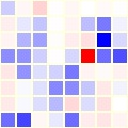

35
Epoch 766 	 reward: 1.5 	 length 2 	 mean_length 1.43 	 epsilon 0.45
Epoch 767 	 reward: 1.5 	 length 2 	 mean_length 1.44 	 epsilon 0.45
Epoch 768 	 reward: 1.5 	 length 2 	 mean_length 1.45 	 epsilon 0.45
Epoch 769 	 reward: 1.5 	 length 2 	 mean_length 1.46 	 epsilon 0.45
Epoch 770 	 reward: -0.5 	 length 1 	 mean_length 1.45 	 epsilon 0.45
Epoch 771 	 reward: 1.5 	 length 2 	 mean_length 1.44 	 epsilon 0.45
Epoch 772 	 reward: -0.5 	 length 1 	 mean_length 1.43 	 epsilon 0.44
Epoch 773 	 reward: -0.5 	 length 1 	 mean_length 1.44 	 epsilon 0.44
Epoch 774 	 reward: 1.5 	 length 2 	 mean_length 1.45 	 epsilon 0.44
Epoch 775 	 reward: 1.5 	 length 2 	 mean_length 1.46 	 epsilon 0.44
Epoch 776 	 reward: 1.5 	 length 2 	 mean_length 1.47 	 epsilon 0.44
Epoch 777 	 reward: -0.5 	 length 1 	 mean_length 1.48 	 epsilon 0.44
Epoch 778 	 reward: 1.5 	 length 2 	 mean_length 1.49 	 epsilon 0.44
Epoch 779 	 reward: -0.5 	 length 1 	 mean_length 1.5 	 epsilon 0.44
Epoch 780 	 reward: 1.5 	 l

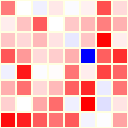

29


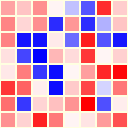

-------------


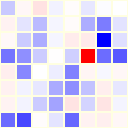

26
Epoch 866 	 reward: -0.5 	 length 1 	 mean_length 1.7 	 epsilon 0.41
Epoch 867 	 reward: -0.5 	 length 1 	 mean_length 1.7 	 epsilon 0.41
Epoch 868 	 reward: -0.5 	 length 1 	 mean_length 1.68 	 epsilon 0.41
Epoch 869 	 reward: -0.5 	 length 1 	 mean_length 1.68 	 epsilon 0.41
Epoch 870 	 reward: -0.5 	 length 1 	 mean_length 1.66 	 epsilon 0.41
Epoch 871 	 reward: 4.0 	 length 3 	 mean_length 1.68 	 epsilon 0.41
Epoch 872 	 reward: -0.5 	 length 1 	 mean_length 1.66 	 epsilon 0.41
Epoch 873 	 reward: 4.0 	 length 3 	 mean_length 1.68 	 epsilon 0.41
Epoch 874 	 reward: 1.5 	 length 2 	 mean_length 1.68 	 epsilon 0.41
Epoch 875 	 reward: -0.5 	 length 1 	 mean_length 1.68 	 epsilon 0.41
Epoch 876 	 reward: 1.5 	 length 2 	 mean_length 1.68 	 epsilon 0.41
Epoch 877 	 reward: -0.5 	 length 1 	 mean_length 1.68 	 epsilon 0.41
Epoch 878 	 reward: 1.5 	 length 2 	 mean_length 1.68 	 epsilon 0.41
Epoch 879 	 reward: -0.5 	 length 1 	 mean_length 1.68 	 epsilon 0.41
Epoch 880 	 reward: 1.5 

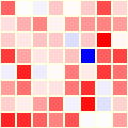

29


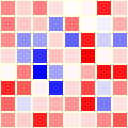

-------------


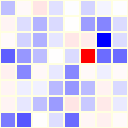

34
Epoch 966 	 reward: 1.5 	 length 2 	 mean_length 1.84 	 epsilon 0.38
Epoch 967 	 reward: 4.0 	 length 3 	 mean_length 1.86 	 epsilon 0.38
Epoch 968 	 reward: 4.0 	 length 3 	 mean_length 1.88 	 epsilon 0.38
Epoch 969 	 reward: -0.5 	 length 1 	 mean_length 1.9 	 epsilon 0.37
Epoch 970 	 reward: 1.5 	 length 2 	 mean_length 1.9 	 epsilon 0.37
Epoch 971 	 reward: 1.5 	 length 2 	 mean_length 1.92 	 epsilon 0.37
Epoch 972 	 reward: 4.0 	 length 3 	 mean_length 1.94 	 epsilon 0.37
Epoch 973 	 reward: -0.5 	 length 1 	 mean_length 1.96 	 epsilon 0.37
Epoch 974 	 reward: 7.0 	 length 4 	 mean_length 2.0 	 epsilon 0.37
Epoch 975 	 reward: -0.5 	 length 1 	 mean_length 2.0 	 epsilon 0.37
Epoch 976 	 reward: -0.5 	 length 1 	 mean_length 1.98 	 epsilon 0.37
Epoch 977 	 reward: -0.5 	 length 1 	 mean_length 1.98 	 epsilon 0.37
Epoch 978 	 reward: 1.5 	 length 2 	 mean_length 1.98 	 epsilon 0.37
Epoch 979 	 reward: -0.5 	 length 1 	 mean_length 1.98 	 epsilon 0.37
Epoch 980 	 reward: 1.5 	 len

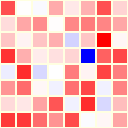

29


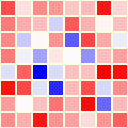

-------------


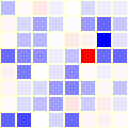

34
Epoch 1066 	 reward: 4.0 	 length 3 	 mean_length 2.13 	 epsilon 0.35
Epoch 1067 	 reward: 4.0 	 length 3 	 mean_length 2.14 	 epsilon 0.34
Epoch 1068 	 reward: -0.5 	 length 1 	 mean_length 2.11 	 epsilon 0.34
Epoch 1069 	 reward: -0.5 	 length 1 	 mean_length 2.1 	 epsilon 0.34
Epoch 1070 	 reward: 4.0 	 length 3 	 mean_length 2.11 	 epsilon 0.34
Epoch 1071 	 reward: 4.0 	 length 3 	 mean_length 2.12 	 epsilon 0.34
Epoch 1072 	 reward: 4.0 	 length 3 	 mean_length 2.13 	 epsilon 0.34
Epoch 1073 	 reward: 1.5 	 length 2 	 mean_length 2.12 	 epsilon 0.34
Epoch 1074 	 reward: 4.0 	 length 3 	 mean_length 2.13 	 epsilon 0.34
Epoch 1075 	 reward: 7.0 	 length 4 	 mean_length 2.1 	 epsilon 0.34
Epoch 1076 	 reward: -0.5 	 length 1 	 mean_length 2.07 	 epsilon 0.34
Epoch 1077 	 reward: 4.0 	 length 3 	 mean_length 2.1 	 epsilon 0.34
Epoch 1078 	 reward: 1.5 	 length 2 	 mean_length 2.09 	 epsilon 0.34
Epoch 1079 	 reward: 1.5 	 length 2 	 mean_length 2.1 	 epsilon 0.34
Epoch 1080 	 rewar

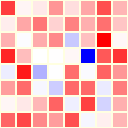

29


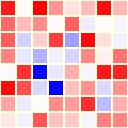

-------------


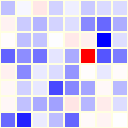

43
Epoch 1166 	 reward: 4.0 	 length 3 	 mean_length 2.17 	 epsilon 0.32
Epoch 1167 	 reward: 1.5 	 length 2 	 mean_length 2.16 	 epsilon 0.32
Epoch 1168 	 reward: 4.0 	 length 3 	 mean_length 2.17 	 epsilon 0.32
Epoch 1169 	 reward: 4.0 	 length 3 	 mean_length 2.2 	 epsilon 0.32
Epoch 1170 	 reward: -0.5 	 length 1 	 mean_length 2.17 	 epsilon 0.32
Epoch 1171 	 reward: -0.5 	 length 1 	 mean_length 2.16 	 epsilon 0.32
Epoch 1172 	 reward: 4.0 	 length 3 	 mean_length 2.17 	 epsilon 0.32
Epoch 1173 	 reward: 4.0 	 length 3 	 mean_length 2.16 	 epsilon 0.32
Epoch 1174 	 reward: 1.5 	 length 2 	 mean_length 2.15 	 epsilon 0.32
Epoch 1175 	 reward: -0.5 	 length 1 	 mean_length 2.14 	 epsilon 0.31
Epoch 1176 	 reward: 4.0 	 length 3 	 mean_length 2.15 	 epsilon 0.31
Epoch 1177 	 reward: 4.0 	 length 3 	 mean_length 2.18 	 epsilon 0.31
Epoch 1178 	 reward: 4.0 	 length 3 	 mean_length 2.19 	 epsilon 0.31
Epoch 1179 	 reward: 4.0 	 length 3 	 mean_length 2.2 	 epsilon 0.31
Epoch 1180 	 rew

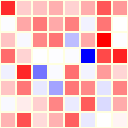

29


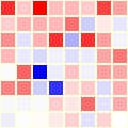

-------------


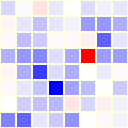

34
Epoch 1266 	 reward: 4.0 	 length 3 	 mean_length 2.25 	 epsilon 0.29
Epoch 1267 	 reward: -0.5 	 length 1 	 mean_length 2.24 	 epsilon 0.29
Epoch 1268 	 reward: -0.5 	 length 1 	 mean_length 2.21 	 epsilon 0.29
Epoch 1269 	 reward: 1.5 	 length 2 	 mean_length 2.2 	 epsilon 0.29
Epoch 1270 	 reward: 1.5 	 length 2 	 mean_length 2.19 	 epsilon 0.29
Epoch 1271 	 reward: -0.5 	 length 1 	 mean_length 2.22 	 epsilon 0.29
Epoch 1272 	 reward: 1.5 	 length 2 	 mean_length 2.21 	 epsilon 0.29
Epoch 1273 	 reward: -0.5 	 length 1 	 mean_length 2.2 	 epsilon 0.29
Epoch 1274 	 reward: 4.0 	 length 3 	 mean_length 2.21 	 epsilon 0.29
Epoch 1275 	 reward: 4.0 	 length 3 	 mean_length 2.22 	 epsilon 0.29
Epoch 1276 	 reward: 4.0 	 length 3 	 mean_length 2.23 	 epsilon 0.29
Epoch 1277 	 reward: -0.5 	 length 1 	 mean_length 2.22 	 epsilon 0.29
Epoch 1278 	 reward: -0.5 	 length 1 	 mean_length 2.19 	 epsilon 0.29
Epoch 1279 	 reward: 7.0 	 length 4 	 mean_length 2.18 	 epsilon 0.29
Epoch 1280 	 

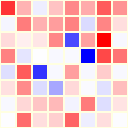

29


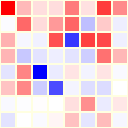

-------------


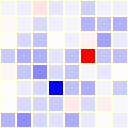

34
Epoch 1366 	 reward: -0.5 	 length 1 	 mean_length 2.49 	 epsilon 0.27
Epoch 1367 	 reward: 1.5 	 length 2 	 mean_length 2.48 	 epsilon 0.27
Epoch 1368 	 reward: 4.0 	 length 3 	 mean_length 2.49 	 epsilon 0.27
Epoch 1369 	 reward: -0.5 	 length 1 	 mean_length 2.52 	 epsilon 0.27
Epoch 1370 	 reward: 7.0 	 length 4 	 mean_length 2.54 	 epsilon 0.27
Epoch 1371 	 reward: 1.5 	 length 2 	 mean_length 2.56 	 epsilon 0.27
Epoch 1372 	 reward: 7.0 	 length 4 	 mean_length 2.58 	 epsilon 0.27
Epoch 1373 	 reward: 7.0 	 length 4 	 mean_length 2.6 	 epsilon 0.27
Epoch 1374 	 reward: -0.5 	 length 1 	 mean_length 2.56 	 epsilon 0.27
Epoch 1375 	 reward: 4.0 	 length 3 	 mean_length 2.56 	 epsilon 0.27
Epoch 1376 	 reward: 7.0 	 length 4 	 mean_length 2.58 	 epsilon 0.27
Epoch 1377 	 reward: -0.5 	 length 1 	 mean_length 2.58 	 epsilon 0.27
Epoch 1378 	 reward: 7.0 	 length 4 	 mean_length 2.6 	 epsilon 0.27
Epoch 1379 	 reward: -0.5 	 length 1 	 mean_length 2.64 	 epsilon 0.27
Epoch 1380 	 r

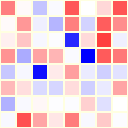

29


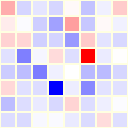

-------------


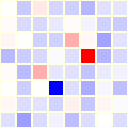

43
Epoch 1466 	 reward: 4.0 	 length 3 	 mean_length 2.64 	 epsilon 0.25
Epoch 1467 	 reward: 1.5 	 length 2 	 mean_length 2.68 	 epsilon 0.25
Epoch 1468 	 reward: -0.5 	 length 1 	 mean_length 2.64 	 epsilon 0.25
Epoch 1469 	 reward: 7.0 	 length 4 	 mean_length 2.64 	 epsilon 0.25
Epoch 1470 	 reward: -0.5 	 length 1 	 mean_length 2.6 	 epsilon 0.25
Epoch 1471 	 reward: 10.5 	 length 5 	 mean_length 2.58 	 epsilon 0.25
Epoch 1472 	 reward: 4.0 	 length 3 	 mean_length 2.58 	 epsilon 0.25
Epoch 1473 	 reward: 4.0 	 length 3 	 mean_length 2.56 	 epsilon 0.25
Epoch 1474 	 reward: 1.5 	 length 2 	 mean_length 2.54 	 epsilon 0.25
Epoch 1475 	 reward: -0.5 	 length 1 	 mean_length 2.58 	 epsilon 0.25
Epoch 1476 	 reward: 10.5 	 length 5 	 mean_length 2.62 	 epsilon 0.25
Epoch 1477 	 reward: 4.0 	 length 3 	 mean_length 2.6 	 epsilon 0.25
Epoch 1478 	 reward: 1.5 	 length 2 	 mean_length 2.58 	 epsilon 0.25
Epoch 1479 	 reward: 1.5 	 length 2 	 mean_length 2.56 	 epsilon 0.25
Epoch 1480 	 r

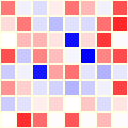

29


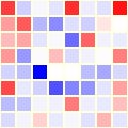

-------------


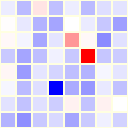

34
Epoch 1566 	 reward: 4.0 	 length 3 	 mean_length 2.68 	 epsilon 0.23
Epoch 1567 	 reward: -0.5 	 length 1 	 mean_length 2.68 	 epsilon 0.23
Epoch 1568 	 reward: 4.0 	 length 3 	 mean_length 2.68 	 epsilon 0.23
Epoch 1569 	 reward: 10.5 	 length 5 	 mean_length 2.72 	 epsilon 0.23
Epoch 1570 	 reward: 1.5 	 length 2 	 mean_length 2.7 	 epsilon 0.23
Epoch 1571 	 reward: 7.0 	 length 4 	 mean_length 2.74 	 epsilon 0.23
Epoch 1572 	 reward: 7.0 	 length 4 	 mean_length 2.76 	 epsilon 0.23
Epoch 1573 	 reward: 7.0 	 length 4 	 mean_length 2.76 	 epsilon 0.23
Epoch 1574 	 reward: 1.5 	 length 2 	 mean_length 2.74 	 epsilon 0.23
Epoch 1575 	 reward: 4.0 	 length 3 	 mean_length 2.76 	 epsilon 0.23
Epoch 1576 	 reward: 7.0 	 length 4 	 mean_length 2.78 	 epsilon 0.23
Epoch 1577 	 reward: 7.0 	 length 4 	 mean_length 2.74 	 epsilon 0.23
Epoch 1578 	 reward: 7.0 	 length 4 	 mean_length 2.76 	 epsilon 0.23
Epoch 1579 	 reward: 10.5 	 length 5 	 mean_length 2.78 	 epsilon 0.23
Epoch 1580 	 re

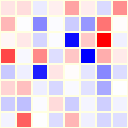

29


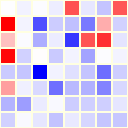

-------------


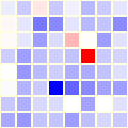

34
Epoch 1666 	 reward: 14.5 	 length 6 	 mean_length 2.94 	 epsilon 0.21
Epoch 1667 	 reward: 4.0 	 length 3 	 mean_length 2.94 	 epsilon 0.21
Epoch 1668 	 reward: 1.5 	 length 2 	 mean_length 2.92 	 epsilon 0.21
Epoch 1669 	 reward: 7.0 	 length 4 	 mean_length 2.92 	 epsilon 0.21
Epoch 1670 	 reward: -0.5 	 length 1 	 mean_length 2.88 	 epsilon 0.21
Epoch 1671 	 reward: 4.0 	 length 3 	 mean_length 2.9 	 epsilon 0.21
Epoch 1672 	 reward: 4.0 	 length 3 	 mean_length 2.9 	 epsilon 0.21
Epoch 1673 	 reward: 19.0 	 length 7 	 mean_length 2.88 	 epsilon 0.21
Epoch 1674 	 reward: 1.5 	 length 2 	 mean_length 2.86 	 epsilon 0.21
Epoch 1675 	 reward: 7.0 	 length 4 	 mean_length 2.88 	 epsilon 0.21
Epoch 1676 	 reward: 1.5 	 length 2 	 mean_length 2.86 	 epsilon 0.21
Epoch 1677 	 reward: 4.0 	 length 3 	 mean_length 2.84 	 epsilon 0.21
Epoch 1678 	 reward: 1.5 	 length 2 	 mean_length 2.82 	 epsilon 0.21
Epoch 1679 	 reward: -0.5 	 length 1 	 mean_length 2.8 	 epsilon 0.21
Epoch 1680 	 rew

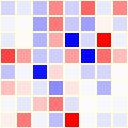

20


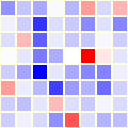

-------------


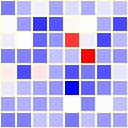

34
Epoch 1766 	 reward: 1.5 	 length 2 	 mean_length 3.27 	 epsilon 0.2
Epoch 1767 	 reward: 4.0 	 length 3 	 mean_length 3.22 	 epsilon 0.2
Epoch 1768 	 reward: -0.5 	 length 1 	 mean_length 3.17 	 epsilon 0.2
Epoch 1769 	 reward: 10.5 	 length 5 	 mean_length 3.2 	 epsilon 0.2
Epoch 1770 	 reward: -0.5 	 length 1 	 mean_length 3.15 	 epsilon 0.2
Epoch 1771 	 reward: 7.0 	 length 4 	 mean_length 3.2 	 epsilon 0.2
Epoch 1772 	 reward: 10.5 	 length 5 	 mean_length 3.23 	 epsilon 0.2
Epoch 1773 	 reward: 1.5 	 length 2 	 mean_length 3.24 	 epsilon 0.2
Epoch 1774 	 reward: -0.5 	 length 1 	 mean_length 3.19 	 epsilon 0.2
Epoch 1775 	 reward: -0.5 	 length 1 	 mean_length 3.22 	 epsilon 0.2
Epoch 1776 	 reward: 7.0 	 length 4 	 mean_length 3.23 	 epsilon 0.2
Epoch 1777 	 reward: 7.0 	 length 4 	 mean_length 3.26 	 epsilon 0.19
Epoch 1778 	 reward: 10.5 	 length 5 	 mean_length 3.29 	 epsilon 0.19
Epoch 1779 	 reward: 10.5 	 length 5 	 mean_length 3.32 	 epsilon 0.19
Epoch 1780 	 reward: -

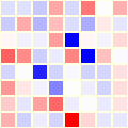

20


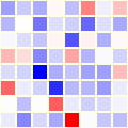

-------------


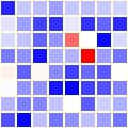

34
Epoch 1866 	 reward: 1.5 	 length 2 	 mean_length 3.0 	 epsilon 0.18
Epoch 1867 	 reward: 7.0 	 length 4 	 mean_length 3.02 	 epsilon 0.18
Epoch 1868 	 reward: 14.5 	 length 6 	 mean_length 3.07 	 epsilon 0.18
Epoch 1869 	 reward: 14.5 	 length 6 	 mean_length 3.12 	 epsilon 0.18
Epoch 1870 	 reward: 1.5 	 length 2 	 mean_length 3.09 	 epsilon 0.18
Epoch 1871 	 reward: 10.5 	 length 5 	 mean_length 3.14 	 epsilon 0.18
Epoch 1872 	 reward: 10.5 	 length 5 	 mean_length 3.17 	 epsilon 0.18
Epoch 1873 	 reward: 19.0 	 length 7 	 mean_length 3.14 	 epsilon 0.18
Epoch 1874 	 reward: 7.0 	 length 4 	 mean_length 3.15 	 epsilon 0.18
Epoch 1875 	 reward: 10.5 	 length 5 	 mean_length 3.2 	 epsilon 0.18
Epoch 1876 	 reward: 7.0 	 length 4 	 mean_length 3.21 	 epsilon 0.18
Epoch 1877 	 reward: 4.0 	 length 3 	 mean_length 3.2 	 epsilon 0.18
Epoch 1878 	 reward: 14.5 	 length 6 	 mean_length 3.25 	 epsilon 0.18
Epoch 1879 	 reward: 10.5 	 length 5 	 mean_length 3.22 	 epsilon 0.18
Epoch 1880 	

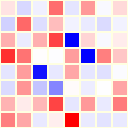

20


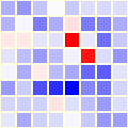

-------------


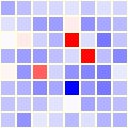

44
Epoch 1966 	 reward: -0.5 	 length 1 	 mean_length 3.33 	 epsilon 0.17
Epoch 1967 	 reward: 4.0 	 length 3 	 mean_length 3.36 	 epsilon 0.17
Epoch 1968 	 reward: 10.5 	 length 5 	 mean_length 3.39 	 epsilon 0.17
Epoch 1969 	 reward: 14.5 	 length 6 	 mean_length 3.34 	 epsilon 0.17
Epoch 1970 	 reward: 7.0 	 length 4 	 mean_length 3.35 	 epsilon 0.17
Epoch 1971 	 reward: -0.5 	 length 1 	 mean_length 3.38 	 epsilon 0.17
Epoch 1972 	 reward: 14.5 	 length 6 	 mean_length 3.43 	 epsilon 0.17
Epoch 1973 	 reward: -0.5 	 length 1 	 mean_length 3.4 	 epsilon 0.17
Epoch 1974 	 reward: 7.0 	 length 4 	 mean_length 3.41 	 epsilon 0.17
Epoch 1975 	 reward: -0.5 	 length 1 	 mean_length 3.4 	 epsilon 0.17
Epoch 1976 	 reward: 1.5 	 length 2 	 mean_length 3.37 	 epsilon 0.17
Epoch 1977 	 reward: 7.0 	 length 4 	 mean_length 3.36 	 epsilon 0.17
Epoch 1978 	 reward: 4.0 	 length 3 	 mean_length 3.35 	 epsilon 0.17
Epoch 1979 	 reward: -0.5 	 length 1 	 mean_length 3.3 	 epsilon 0.17
Epoch 1980 	

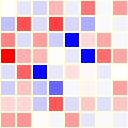

29


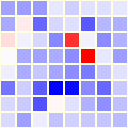

-------------


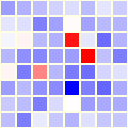

43
Epoch 2066 	 reward: 19.0 	 length 7 	 mean_length 3.5 	 epsilon 0.16
Epoch 2067 	 reward: 7.0 	 length 4 	 mean_length 3.56 	 epsilon 0.16
Epoch 2068 	 reward: 10.5 	 length 5 	 mean_length 3.58 	 epsilon 0.16
Epoch 2069 	 reward: -0.5 	 length 1 	 mean_length 3.56 	 epsilon 0.16
Epoch 2070 	 reward: 1.5 	 length 2 	 mean_length 3.52 	 epsilon 0.16
Epoch 2071 	 reward: -0.5 	 length 1 	 mean_length 3.52 	 epsilon 0.16
Epoch 2072 	 reward: 14.5 	 length 6 	 mean_length 3.56 	 epsilon 0.16
Epoch 2073 	 reward: -0.5 	 length 1 	 mean_length 3.52 	 epsilon 0.16
Epoch 2074 	 reward: 10.5 	 length 5 	 mean_length 3.54 	 epsilon 0.16
Epoch 2075 	 reward: -0.5 	 length 1 	 mean_length 3.54 	 epsilon 0.16
Epoch 2076 	 reward: 14.5 	 length 6 	 mean_length 3.58 	 epsilon 0.16
Epoch 2077 	 reward: 4.0 	 length 3 	 mean_length 3.62 	 epsilon 0.16
Epoch 2078 	 reward: 1.5 	 length 2 	 mean_length 3.58 	 epsilon 0.16
Epoch 2079 	 reward: 29.5 	 length 9 	 mean_length 3.6 	 epsilon 0.16
Epoch 208

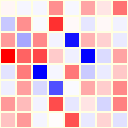

34


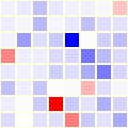

-------------


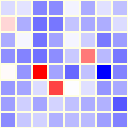

20
Epoch 2166 	 reward: 7.0 	 length 4 	 mean_length 3.72 	 epsilon 0.15
Epoch 2167 	 reward: 4.0 	 length 3 	 mean_length 3.66 	 epsilon 0.15
Epoch 2168 	 reward: -0.5 	 length 1 	 mean_length 3.6 	 epsilon 0.15
Epoch 2169 	 reward: 10.5 	 length 5 	 mean_length 3.58 	 epsilon 0.15
Epoch 2170 	 reward: 14.5 	 length 6 	 mean_length 3.62 	 epsilon 0.15
Epoch 2171 	 reward: 1.5 	 length 2 	 mean_length 3.66 	 epsilon 0.15
Epoch 2172 	 reward: 10.5 	 length 5 	 mean_length 3.68 	 epsilon 0.15
Epoch 2173 	 reward: -0.5 	 length 1 	 mean_length 3.64 	 epsilon 0.15
Epoch 2174 	 reward: 1.5 	 length 2 	 mean_length 3.6 	 epsilon 0.15
Epoch 2175 	 reward: 7.0 	 length 4 	 mean_length 3.58 	 epsilon 0.15
Epoch 2176 	 reward: 14.5 	 length 6 	 mean_length 3.62 	 epsilon 0.15
Epoch 2177 	 reward: -0.5 	 length 1 	 mean_length 3.58 	 epsilon 0.15
Epoch 2178 	 reward: 1.5 	 length 2 	 mean_length 3.54 	 epsilon 0.15
Epoch 2179 	 reward: -0.5 	 length 1 	 mean_length 3.58 	 epsilon 0.15
Epoch 2180 

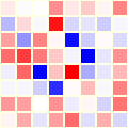

29


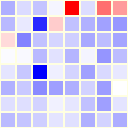

-------------


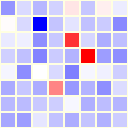

34
Epoch 2266 	 reward: 7.0 	 length 4 	 mean_length 3.76 	 epsilon 0.14
Epoch 2267 	 reward: 10.5 	 length 5 	 mean_length 3.76 	 epsilon 0.14
Epoch 2268 	 reward: -0.5 	 length 1 	 mean_length 3.7 	 epsilon 0.14
Epoch 2269 	 reward: 29.5 	 length 9 	 mean_length 3.76 	 epsilon 0.14
Epoch 2270 	 reward: 1.5 	 length 2 	 mean_length 3.72 	 epsilon 0.14
Epoch 2271 	 reward: 10.5 	 length 5 	 mean_length 3.68 	 epsilon 0.14
Epoch 2272 	 reward: -0.5 	 length 1 	 mean_length 3.62 	 epsilon 0.14
Epoch 2273 	 reward: 7.0 	 length 4 	 mean_length 3.6 	 epsilon 0.14
Epoch 2274 	 reward: 10.5 	 length 5 	 mean_length 3.62 	 epsilon 0.14
Epoch 2275 	 reward: 7.0 	 length 4 	 mean_length 3.66 	 epsilon 0.14
Epoch 2276 	 reward: 1.5 	 length 2 	 mean_length 3.62 	 epsilon 0.14
Epoch 2277 	 reward: -0.5 	 length 1 	 mean_length 3.58 	 epsilon 0.14
Epoch 2278 	 reward: 4.0 	 length 3 	 mean_length 3.56 	 epsilon 0.14
Epoch 2279 	 reward: 4.0 	 length 3 	 mean_length 3.6 	 epsilon 0.14
Epoch 2280 	 

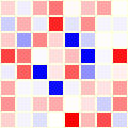

29


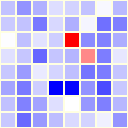

-------------


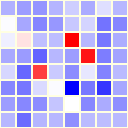

43
Epoch 2366 	 reward: 10.5 	 length 5 	 mean_length 4.05 	 epsilon 0.13
Epoch 2367 	 reward: 7.0 	 length 4 	 mean_length 4.05 	 epsilon 0.13
Epoch 2368 	 reward: 19.0 	 length 7 	 mean_length 4.11 	 epsilon 0.13
Epoch 2369 	 reward: 7.0 	 length 4 	 mean_length 4.18 	 epsilon 0.13
Epoch 2370 	 reward: 14.5 	 length 6 	 mean_length 4.21 	 epsilon 0.13
Epoch 2371 	 reward: 4.0 	 length 3 	 mean_length 4.26 	 epsilon 0.13
Epoch 2372 	 reward: -0.5 	 length 1 	 mean_length 4.19 	 epsilon 0.13
Epoch 2373 	 reward: -0.5 	 length 1 	 mean_length 4.26 	 epsilon 0.13
Epoch 2374 	 reward: 1.5 	 length 2 	 mean_length 4.21 	 epsilon 0.13
Epoch 2375 	 reward: 10.5 	 length 5 	 mean_length 4.2 	 epsilon 0.13
Epoch 2376 	 reward: 1.5 	 length 2 	 mean_length 4.15 	 epsilon 0.13
Epoch 2377 	 reward: 19.0 	 length 7 	 mean_length 4.2 	 epsilon 0.13
Epoch 2378 	 reward: 19.0 	 length 7 	 mean_length 4.25 	 epsilon 0.13
Epoch 2379 	 reward: 10.5 	 length 5 	 mean_length 4.28 	 epsilon 0.13
Epoch 2380

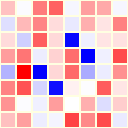

29


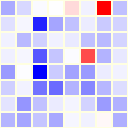

-------------


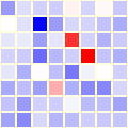

34
Epoch 2466 	 reward: 7.0 	 length 4 	 mean_length 4.39 	 epsilon 0.12
Epoch 2467 	 reward: 4.0 	 length 3 	 mean_length 4.38 	 epsilon 0.12
Epoch 2468 	 reward: 10.5 	 length 5 	 mean_length 4.39 	 epsilon 0.12
Epoch 2469 	 reward: 10.5 	 length 5 	 mean_length 4.34 	 epsilon 0.12
Epoch 2470 	 reward: 19.0 	 length 7 	 mean_length 4.39 	 epsilon 0.12
Epoch 2471 	 reward: -0.5 	 length 1 	 mean_length 4.36 	 epsilon 0.12
Epoch 2472 	 reward: 19.0 	 length 7 	 mean_length 4.41 	 epsilon 0.12
Epoch 2473 	 reward: 14.5 	 length 6 	 mean_length 4.48 	 epsilon 0.12
Epoch 2474 	 reward: 14.5 	 length 6 	 mean_length 4.5 	 epsilon 0.12
Epoch 2475 	 reward: 7.0 	 length 4 	 mean_length 4.55 	 epsilon 0.12
Epoch 2476 	 reward: 14.5 	 length 6 	 mean_length 4.58 	 epsilon 0.12
Epoch 2477 	 reward: 14.5 	 length 6 	 mean_length 4.63 	 epsilon 0.12
Epoch 2478 	 reward: 10.5 	 length 5 	 mean_length 4.64 	 epsilon 0.12
Epoch 2479 	 reward: 1.5 	 length 2 	 mean_length 4.59 	 epsilon 0.12
Epoch 24

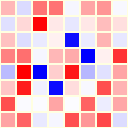

34


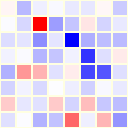

-------------


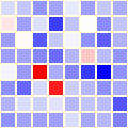

20
Epoch 2566 	 reward: 10.5 	 length 5 	 mean_length 4.17 	 epsilon 0.11
Epoch 2567 	 reward: 1.5 	 length 2 	 mean_length 4.18 	 epsilon 0.11
Epoch 2568 	 reward: -0.5 	 length 1 	 mean_length 4.11 	 epsilon 0.11
Epoch 2569 	 reward: 19.0 	 length 7 	 mean_length 4.09 	 epsilon 0.11
Epoch 2570 	 reward: 1.5 	 length 2 	 mean_length 4.05 	 epsilon 0.11
Epoch 2571 	 reward: 14.5 	 length 6 	 mean_length 4.0 	 epsilon 0.11
Epoch 2572 	 reward: 10.5 	 length 5 	 mean_length 4.01 	 epsilon 0.11
Epoch 2573 	 reward: -0.5 	 length 1 	 mean_length 3.96 	 epsilon 0.11
Epoch 2574 	 reward: 29.5 	 length 9 	 mean_length 4.05 	 epsilon 0.11
Epoch 2575 	 reward: 7.0 	 length 4 	 mean_length 4.01 	 epsilon 0.11
Epoch 2576 	 reward: 1.5 	 length 2 	 mean_length 3.98 	 epsilon 0.11
Epoch 2577 	 reward: 7.0 	 length 4 	 mean_length 3.94 	 epsilon 0.11
Epoch 2578 	 reward: 10.5 	 length 5 	 mean_length 3.96 	 epsilon 0.11
Epoch 2579 	 reward: 19.0 	 length 7 	 mean_length 3.94 	 epsilon 0.11
Epoch 258

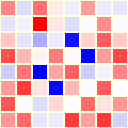

34


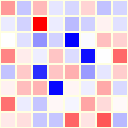

-------------


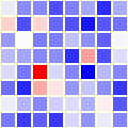

20
Epoch 2666 	 reward: -0.5 	 length 1 	 mean_length 4.62 	 epsilon 0.11
Epoch 2667 	 reward: 14.5 	 length 6 	 mean_length 4.62 	 epsilon 0.11
Epoch 2668 	 reward: 7.0 	 length 4 	 mean_length 4.6 	 epsilon 0.11
Epoch 2669 	 reward: 1.5 	 length 2 	 mean_length 4.68 	 epsilon 0.11
Epoch 2670 	 reward: 1.5 	 length 2 	 mean_length 4.62 	 epsilon 0.11
Epoch 2671 	 reward: 10.5 	 length 5 	 mean_length 4.68 	 epsilon 0.11
Epoch 2672 	 reward: 14.5 	 length 6 	 mean_length 4.7 	 epsilon 0.11
Epoch 2673 	 reward: 7.0 	 length 4 	 mean_length 4.7 	 epsilon 0.11
Epoch 2674 	 reward: 1.5 	 length 2 	 mean_length 4.64 	 epsilon 0.11
Epoch 2675 	 reward: -0.5 	 length 1 	 mean_length 4.55 	 epsilon 0.11
Epoch 2676 	 reward: 19.0 	 length 7 	 mean_length 4.6 	 epsilon 0.11
Epoch 2677 	 reward: 7.0 	 length 4 	 mean_length 4.66 	 epsilon 0.11
Epoch 2678 	 reward: 7.0 	 length 4 	 mean_length 4.64 	 epsilon 0.11
Epoch 2679 	 reward: 10.5 	 length 5 	 mean_length 4.63 	 epsilon 0.11
Epoch 2680 	 r

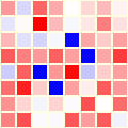

43


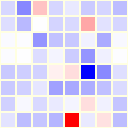

-------------


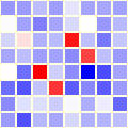

37
Epoch 2766 	 reward: 7.0 	 length 4 	 mean_length 4.19 	 epsilon 0.1
Epoch 2767 	 reward: -0.5 	 length 1 	 mean_length 4.26 	 epsilon 0.1
Epoch 2768 	 reward: 14.5 	 length 6 	 mean_length 4.29 	 epsilon 0.1
Epoch 2769 	 reward: 24.0 	 length 8 	 mean_length 4.3 	 epsilon 0.1
Epoch 2770 	 reward: -0.5 	 length 1 	 mean_length 4.23 	 epsilon 0.1
Epoch 2771 	 reward: -0.5 	 length 1 	 mean_length 4.28 	 epsilon 0.1
Epoch 2772 	 reward: 10.5 	 length 5 	 mean_length 4.29 	 epsilon 0.1
Epoch 2773 	 reward: 10.5 	 length 5 	 mean_length 4.26 	 epsilon 0.1
Epoch 2774 	 reward: 10.5 	 length 5 	 mean_length 4.27 	 epsilon 0.1
Epoch 2775 	 reward: 19.0 	 length 7 	 mean_length 4.32 	 epsilon 0.1
Epoch 2776 	 reward: 7.0 	 length 4 	 mean_length 4.31 	 epsilon 0.1
Epoch 2777 	 reward: 14.5 	 length 6 	 mean_length 4.26 	 epsilon 0.1
Epoch 2778 	 reward: 19.0 	 length 7 	 mean_length 4.31 	 epsilon 0.1
Epoch 2779 	 reward: 19.0 	 length 7 	 mean_length 4.32 	 epsilon 0.1
Epoch 2780 	 reward:

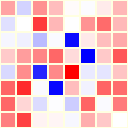

29


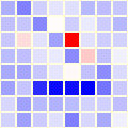

-------------


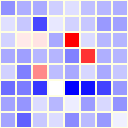

45
Epoch 2866 	 reward: 14.5 	 length 6 	 mean_length 4.5 	 epsilon 0.1
Epoch 2867 	 reward: 19.0 	 length 7 	 mean_length 4.51 	 epsilon 0.1
Epoch 2868 	 reward: 10.5 	 length 5 	 mean_length 4.52 	 epsilon 0.1
Epoch 2869 	 reward: 29.5 	 length 9 	 mean_length 4.5 	 epsilon 0.1
Epoch 2870 	 reward: 1.5 	 length 2 	 mean_length 4.45 	 epsilon 0.1
Epoch 2871 	 reward: 29.5 	 length 9 	 mean_length 4.51 	 epsilon 0.1
Epoch 2872 	 reward: 10.5 	 length 5 	 mean_length 4.52 	 epsilon 0.1
Epoch 2873 	 reward: 24.0 	 length 8 	 mean_length 4.51 	 epsilon 0.1
Epoch 2874 	 reward: 1.5 	 length 2 	 mean_length 4.47 	 epsilon 0.1
Epoch 2875 	 reward: 4.0 	 length 3 	 mean_length 4.46 	 epsilon 0.1
Epoch 2876 	 reward: 14.5 	 length 6 	 mean_length 4.49 	 epsilon 0.1
Epoch 2877 	 reward: 7.0 	 length 4 	 mean_length 4.5 	 epsilon 0.1
Epoch 2878 	 reward: 19.0 	 length 7 	 mean_length 4.54 	 epsilon 0.1
Epoch 2879 	 reward: 10.5 	 length 5 	 mean_length 4.5 	 epsilon 0.1
Epoch 2880 	 reward: 4.0 

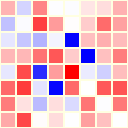

29


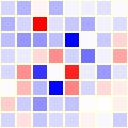

-------------


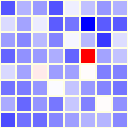

20
Epoch 2966 	 reward: 10.5 	 length 5 	 mean_length 4.76 	 epsilon 0.09
Epoch 2967 	 reward: 10.5 	 length 5 	 mean_length 4.74 	 epsilon 0.09
Epoch 2968 	 reward: -0.5 	 length 1 	 mean_length 4.66 	 epsilon 0.09
Epoch 2969 	 reward: 7.0 	 length 4 	 mean_length 4.66 	 epsilon 0.09
Epoch 2970 	 reward: 14.5 	 length 6 	 mean_length 4.68 	 epsilon 0.09
Epoch 2971 	 reward: 4.0 	 length 3 	 mean_length 4.74 	 epsilon 0.09
Epoch 2972 	 reward: 19.0 	 length 7 	 mean_length 4.78 	 epsilon 0.09
Epoch 2973 	 reward: 10.5 	 length 5 	 mean_length 4.78 	 epsilon 0.09
Epoch 2974 	 reward: 24.0 	 length 8 	 mean_length 4.84 	 epsilon 0.09
Epoch 2975 	 reward: 14.5 	 length 6 	 mean_length 4.9 	 epsilon 0.09
Epoch 2976 	 reward: 29.5 	 length 9 	 mean_length 4.98 	 epsilon 0.09
Epoch 2977 	 reward: 24.0 	 length 8 	 mean_length 4.96 	 epsilon 0.09
Epoch 2978 	 reward: 10.5 	 length 5 	 mean_length 4.96 	 epsilon 0.09
Epoch 2979 	 reward: 14.5 	 length 6 	 mean_length 4.92 	 epsilon 0.09
Epoch 

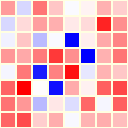

29


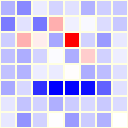

-------------


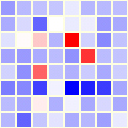

43
Epoch 3066 	 reward: 19.0 	 length 7 	 mean_length 4.68 	 epsilon 0.09
Epoch 3067 	 reward: 1.5 	 length 2 	 mean_length 4.68 	 epsilon 0.09
Epoch 3068 	 reward: 10.5 	 length 5 	 mean_length 4.68 	 epsilon 0.09
Epoch 3069 	 reward: 29.5 	 length 9 	 mean_length 4.76 	 epsilon 0.09
Epoch 3070 	 reward: 24.0 	 length 8 	 mean_length 4.82 	 epsilon 0.09
Epoch 3071 	 reward: 19.0 	 length 7 	 mean_length 4.8 	 epsilon 0.09
Epoch 3072 	 reward: 10.5 	 length 5 	 mean_length 4.8 	 epsilon 0.09
Epoch 3073 	 reward: 10.5 	 length 5 	 mean_length 4.76 	 epsilon 0.09
Epoch 3074 	 reward: 1.5 	 length 2 	 mean_length 4.7 	 epsilon 0.09
Epoch 3075 	 reward: -0.5 	 length 1 	 mean_length 4.63 	 epsilon 0.09
Epoch 3076 	 reward: 7.0 	 length 4 	 mean_length 4.62 	 epsilon 0.09
Epoch 3077 	 reward: 14.5 	 length 6 	 mean_length 4.54 	 epsilon 0.09
Epoch 3078 	 reward: 1.5 	 length 2 	 mean_length 4.49 	 epsilon 0.09
Epoch 3079 	 reward: 14.5 	 length 6 	 mean_length 4.48 	 epsilon 0.09
Epoch 3080

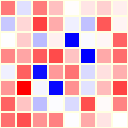

29


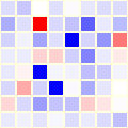

-------------


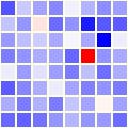

20
Epoch 3166 	 reward: 10.5 	 length 5 	 mean_length 5.47 	 epsilon 0.08
Epoch 3167 	 reward: -0.5 	 length 1 	 mean_length 5.44 	 epsilon 0.08
Epoch 3168 	 reward: 24.0 	 length 8 	 mean_length 5.49 	 epsilon 0.08
Epoch 3169 	 reward: 4.0 	 length 3 	 mean_length 5.5 	 epsilon 0.08
Epoch 3170 	 reward: 24.0 	 length 8 	 mean_length 5.54 	 epsilon 0.08
Epoch 3171 	 reward: 14.5 	 length 6 	 mean_length 5.5 	 epsilon 0.08
Epoch 3172 	 reward: 7.0 	 length 4 	 mean_length 5.47 	 epsilon 0.08
Epoch 3173 	 reward: 10.5 	 length 5 	 mean_length 5.48 	 epsilon 0.08
Epoch 3174 	 reward: 24.0 	 length 8 	 mean_length 5.52 	 epsilon 0.08
Epoch 3175 	 reward: 10.5 	 length 5 	 mean_length 5.6 	 epsilon 0.08
Epoch 3176 	 reward: 7.0 	 length 4 	 mean_length 5.56 	 epsilon 0.08
Epoch 3177 	 reward: 14.5 	 length 6 	 mean_length 5.6 	 epsilon 0.08
Epoch 3178 	 reward: 10.5 	 length 5 	 mean_length 5.58 	 epsilon 0.08
Epoch 3179 	 reward: -0.5 	 length 1 	 mean_length 5.66 	 epsilon 0.08
Epoch 3180

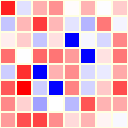

34


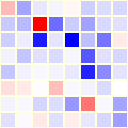

-------------


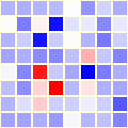

20
Epoch 3266 	 reward: 1.5 	 length 2 	 mean_length 5.25 	 epsilon 0.08
Epoch 3267 	 reward: 19.0 	 length 7 	 mean_length 5.26 	 epsilon 0.08
Epoch 3268 	 reward: 4.0 	 length 3 	 mean_length 5.21 	 epsilon 0.08
Epoch 3269 	 reward: 4.0 	 length 3 	 mean_length 5.16 	 epsilon 0.08
Epoch 3270 	 reward: 14.5 	 length 6 	 mean_length 5.17 	 epsilon 0.08
Epoch 3271 	 reward: 14.5 	 length 6 	 mean_length 5.12 	 epsilon 0.08
Epoch 3272 	 reward: 7.0 	 length 4 	 mean_length 5.09 	 epsilon 0.08
Epoch 3273 	 reward: 14.5 	 length 6 	 mean_length 5.12 	 epsilon 0.08
Epoch 3274 	 reward: 10.5 	 length 5 	 mean_length 5.11 	 epsilon 0.08
Epoch 3275 	 reward: 7.0 	 length 4 	 mean_length 5.05 	 epsilon 0.08
Epoch 3276 	 reward: 14.5 	 length 6 	 mean_length 5.07 	 epsilon 0.08
Epoch 3277 	 reward: 10.5 	 length 5 	 mean_length 5.09 	 epsilon 0.08
Epoch 3278 	 reward: 19.0 	 length 7 	 mean_length 5.13 	 epsilon 0.08
Epoch 3279 	 reward: 24.0 	 length 8 	 mean_length 5.14 	 epsilon 0.08
Epoch 32

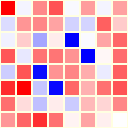

20


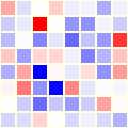

-------------


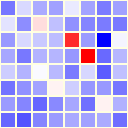

34
Epoch 3366 	 reward: 14.5 	 length 6 	 mean_length 5.11 	 epsilon 0.08
Epoch 3367 	 reward: 24.0 	 length 8 	 mean_length 5.18 	 epsilon 0.08
Epoch 3368 	 reward: 14.5 	 length 6 	 mean_length 5.19 	 epsilon 0.08
Epoch 3369 	 reward: 7.0 	 length 4 	 mean_length 5.24 	 epsilon 0.08
Epoch 3370 	 reward: 14.5 	 length 6 	 mean_length 5.25 	 epsilon 0.08
Epoch 3371 	 reward: -0.5 	 length 1 	 mean_length 5.24 	 epsilon 0.08
Epoch 3372 	 reward: 14.5 	 length 6 	 mean_length 5.25 	 epsilon 0.08
Epoch 3373 	 reward: 7.0 	 length 4 	 mean_length 5.28 	 epsilon 0.08
Epoch 3374 	 reward: 19.0 	 length 7 	 mean_length 5.31 	 epsilon 0.08
Epoch 3375 	 reward: 24.0 	 length 8 	 mean_length 5.32 	 epsilon 0.08
Epoch 3376 	 reward: 10.5 	 length 5 	 mean_length 5.31 	 epsilon 0.08
Epoch 3377 	 reward: 10.5 	 length 5 	 mean_length 5.3 	 epsilon 0.08
Epoch 3378 	 reward: 1.5 	 length 2 	 mean_length 5.23 	 epsilon 0.08
Epoch 3379 	 reward: 19.0 	 length 7 	 mean_length 5.2 	 epsilon 0.08
Epoch 33

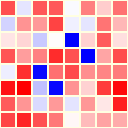

20


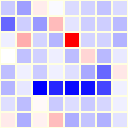

-------------


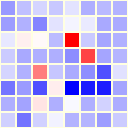

42
Epoch 3466 	 reward: 7.0 	 length 4 	 mean_length 5.25 	 epsilon 0.07
Epoch 3467 	 reward: 14.5 	 length 6 	 mean_length 5.24 	 epsilon 0.07
Epoch 3468 	 reward: 10.5 	 length 5 	 mean_length 5.23 	 epsilon 0.07
Epoch 3469 	 reward: 24.0 	 length 8 	 mean_length 5.22 	 epsilon 0.07
Epoch 3470 	 reward: 14.5 	 length 6 	 mean_length 5.23 	 epsilon 0.07
Epoch 3471 	 reward: 24.0 	 length 8 	 mean_length 5.22 	 epsilon 0.07
Epoch 3472 	 reward: 7.0 	 length 4 	 mean_length 5.19 	 epsilon 0.07
Epoch 3473 	 reward: 19.0 	 length 7 	 mean_length 5.18 	 epsilon 0.07
Epoch 3474 	 reward: 14.5 	 length 6 	 mean_length 5.19 	 epsilon 0.07
Epoch 3475 	 reward: 10.5 	 length 5 	 mean_length 5.16 	 epsilon 0.07
Epoch 3476 	 reward: 7.0 	 length 4 	 mean_length 5.13 	 epsilon 0.07
Epoch 3477 	 reward: 7.0 	 length 4 	 mean_length 5.14 	 epsilon 0.07
Epoch 3478 	 reward: 14.5 	 length 6 	 mean_length 5.15 	 epsilon 0.07
Epoch 3479 	 reward: 19.0 	 length 7 	 mean_length 5.22 	 epsilon 0.07
Epoch 3

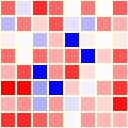

43


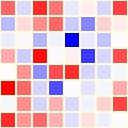

-------------


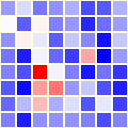

20
Epoch 3566 	 reward: 14.5 	 length 6 	 mean_length 5.01 	 epsilon 0.07
Epoch 3567 	 reward: 10.5 	 length 5 	 mean_length 5.04 	 epsilon 0.07
Epoch 3568 	 reward: 19.0 	 length 7 	 mean_length 5.07 	 epsilon 0.07
Epoch 3569 	 reward: 10.5 	 length 5 	 mean_length 5.08 	 epsilon 0.07
Epoch 3570 	 reward: 24.0 	 length 8 	 mean_length 5.13 	 epsilon 0.07
Epoch 3571 	 reward: 7.0 	 length 4 	 mean_length 5.12 	 epsilon 0.07
Epoch 3572 	 reward: 19.0 	 length 7 	 mean_length 5.15 	 epsilon 0.07
Epoch 3573 	 reward: 7.0 	 length 4 	 mean_length 5.18 	 epsilon 0.07
Epoch 3574 	 reward: 19.0 	 length 7 	 mean_length 5.21 	 epsilon 0.07
Epoch 3575 	 reward: 10.5 	 length 5 	 mean_length 5.2 	 epsilon 0.07
Epoch 3576 	 reward: 10.5 	 length 5 	 mean_length 5.19 	 epsilon 0.07
Epoch 3577 	 reward: 29.5 	 length 9 	 mean_length 5.22 	 epsilon 0.07
Epoch 3578 	 reward: 1.5 	 length 2 	 mean_length 5.15 	 epsilon 0.07
Epoch 3579 	 reward: 10.5 	 length 5 	 mean_length 5.14 	 epsilon 0.07
Epoch 3

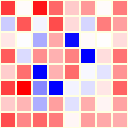

29


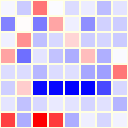

-------------


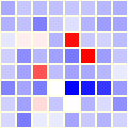

44
Epoch 3666 	 reward: 19.0 	 length 7 	 mean_length 5.35 	 epsilon 0.07
Epoch 3667 	 reward: 24.0 	 length 8 	 mean_length 5.34 	 epsilon 0.07
Epoch 3668 	 reward: 7.0 	 length 4 	 mean_length 5.31 	 epsilon 0.07
Epoch 3669 	 reward: 19.0 	 length 7 	 mean_length 5.28 	 epsilon 0.07
Epoch 3670 	 reward: 10.5 	 length 5 	 mean_length 5.27 	 epsilon 0.07
Epoch 3671 	 reward: 24.0 	 length 8 	 mean_length 5.22 	 epsilon 0.07
Epoch 3672 	 reward: 24.0 	 length 8 	 mean_length 5.27 	 epsilon 0.07
Epoch 3673 	 reward: 19.0 	 length 7 	 mean_length 5.24 	 epsilon 0.07
Epoch 3674 	 reward: 19.0 	 length 7 	 mean_length 5.27 	 epsilon 0.07
Epoch 3675 	 reward: 29.5 	 length 9 	 mean_length 5.24 	 epsilon 0.07
Epoch 3676 	 reward: 24.0 	 length 8 	 mean_length 5.29 	 epsilon 0.07
Epoch 3677 	 reward: 29.5 	 length 9 	 mean_length 5.3 	 epsilon 0.07
Epoch 3678 	 reward: -0.5 	 length 1 	 mean_length 5.21 	 epsilon 0.07
Epoch 3679 	 reward: 4.0 	 length 3 	 mean_length 5.28 	 epsilon 0.07
Epoch 

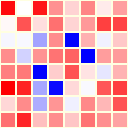

29


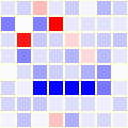

-------------


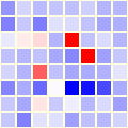

44
Epoch 3766 	 reward: 14.5 	 length 6 	 mean_length 5.31 	 epsilon 0.07
Epoch 3767 	 reward: 7.0 	 length 4 	 mean_length 5.28 	 epsilon 0.07
Epoch 3768 	 reward: 14.5 	 length 6 	 mean_length 5.29 	 epsilon 0.07
Epoch 3769 	 reward: 29.5 	 length 9 	 mean_length 5.32 	 epsilon 0.07
Epoch 3770 	 reward: 10.5 	 length 5 	 mean_length 5.31 	 epsilon 0.07
Epoch 3771 	 reward: 19.0 	 length 7 	 mean_length 5.32 	 epsilon 0.07
Epoch 3772 	 reward: 24.0 	 length 8 	 mean_length 5.37 	 epsilon 0.07
Epoch 3773 	 reward: 19.0 	 length 7 	 mean_length 5.32 	 epsilon 0.07
Epoch 3774 	 reward: 19.0 	 length 7 	 mean_length 5.35 	 epsilon 0.07
Epoch 3775 	 reward: 7.0 	 length 4 	 mean_length 5.32 	 epsilon 0.07
Epoch 3776 	 reward: 10.5 	 length 5 	 mean_length 5.31 	 epsilon 0.07
Epoch 3777 	 reward: 19.0 	 length 7 	 mean_length 5.26 	 epsilon 0.07
Epoch 3778 	 reward: 4.0 	 length 3 	 mean_length 5.21 	 epsilon 0.07
Epoch 3779 	 reward: 19.0 	 length 7 	 mean_length 5.3 	 epsilon 0.07
Epoch 3

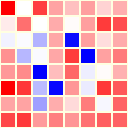

29


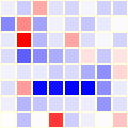

-------------


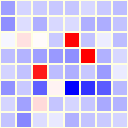

45
Epoch 3866 	 reward: 10.5 	 length 5 	 mean_length 5.96 	 epsilon 0.06
Epoch 3867 	 reward: 14.5 	 length 6 	 mean_length 5.96 	 epsilon 0.06
Epoch 3868 	 reward: 24.0 	 length 8 	 mean_length 6.0 	 epsilon 0.06
Epoch 3869 	 reward: 19.0 	 length 7 	 mean_length 6.0 	 epsilon 0.06
Epoch 3870 	 reward: 10.5 	 length 5 	 mean_length 5.98 	 epsilon 0.06
Epoch 3871 	 reward: -0.5 	 length 1 	 mean_length 6.0 	 epsilon 0.06
Epoch 3872 	 reward: 10.5 	 length 5 	 mean_length 5.98 	 epsilon 0.06
Epoch 3873 	 reward: 19.0 	 length 7 	 mean_length 5.94 	 epsilon 0.06
Epoch 3874 	 reward: 7.0 	 length 4 	 mean_length 5.9 	 epsilon 0.06
Epoch 3875 	 reward: 14.5 	 length 6 	 mean_length 5.88 	 epsilon 0.06
Epoch 3876 	 reward: 10.5 	 length 5 	 mean_length 5.86 	 epsilon 0.06
Epoch 3877 	 reward: 19.0 	 length 7 	 mean_length 5.88 	 epsilon 0.06
Epoch 3878 	 reward: 10.5 	 length 5 	 mean_length 5.86 	 epsilon 0.06
Epoch 3879 	 reward: 24.0 	 length 8 	 mean_length 5.92 	 epsilon 0.06
Epoch 38

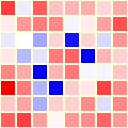

34


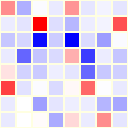

-------------


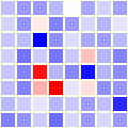

20
Epoch 3966 	 reward: 7.0 	 length 4 	 mean_length 5.68 	 epsilon 0.06
Epoch 3967 	 reward: 7.0 	 length 4 	 mean_length 5.7 	 epsilon 0.06
Epoch 3968 	 reward: 14.5 	 length 6 	 mean_length 5.7 	 epsilon 0.06
Epoch 3969 	 reward: 19.0 	 length 7 	 mean_length 5.66 	 epsilon 0.06
Epoch 3970 	 reward: 7.0 	 length 4 	 mean_length 5.62 	 epsilon 0.06
Epoch 3971 	 reward: 14.5 	 length 6 	 mean_length 5.64 	 epsilon 0.06
Epoch 3972 	 reward: 24.0 	 length 8 	 mean_length 5.68 	 epsilon 0.06
Epoch 3973 	 reward: 24.0 	 length 8 	 mean_length 5.7 	 epsilon 0.06
Epoch 3974 	 reward: 19.0 	 length 7 	 mean_length 5.72 	 epsilon 0.06
Epoch 3975 	 reward: 10.5 	 length 5 	 mean_length 5.76 	 epsilon 0.06
Epoch 3976 	 reward: 10.5 	 length 5 	 mean_length 5.74 	 epsilon 0.06
Epoch 3977 	 reward: 19.0 	 length 7 	 mean_length 5.76 	 epsilon 0.06
Epoch 3978 	 reward: 4.0 	 length 3 	 mean_length 5.7 	 epsilon 0.06
Epoch 3979 	 reward: 19.0 	 length 7 	 mean_length 5.72 	 epsilon 0.06
Epoch 3980 

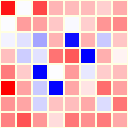

29


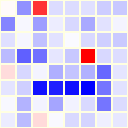

-------------


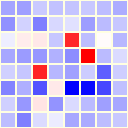

45
Epoch 4066 	 reward: -0.5 	 length 1 	 mean_length 5.9 	 epsilon 0.06
Epoch 4067 	 reward: 19.0 	 length 7 	 mean_length 5.94 	 epsilon 0.06
Epoch 4068 	 reward: 19.0 	 length 7 	 mean_length 5.96 	 epsilon 0.06
Epoch 4069 	 reward: 24.0 	 length 8 	 mean_length 5.96 	 epsilon 0.06
Epoch 4070 	 reward: -0.5 	 length 1 	 mean_length 5.86 	 epsilon 0.06
Epoch 4071 	 reward: 19.0 	 length 7 	 mean_length 5.9 	 epsilon 0.06
Epoch 4072 	 reward: 19.0 	 length 7 	 mean_length 5.92 	 epsilon 0.06
Epoch 4073 	 reward: 14.5 	 length 6 	 mean_length 5.88 	 epsilon 0.06
Epoch 4074 	 reward: 10.5 	 length 5 	 mean_length 5.86 	 epsilon 0.06
Epoch 4075 	 reward: 19.0 	 length 7 	 mean_length 5.84 	 epsilon 0.06
Epoch 4076 	 reward: 7.0 	 length 4 	 mean_length 5.8 	 epsilon 0.06
Epoch 4077 	 reward: 10.5 	 length 5 	 mean_length 5.82 	 epsilon 0.06
Epoch 4078 	 reward: 10.5 	 length 5 	 mean_length 5.8 	 epsilon 0.06
Epoch 4079 	 reward: 19.0 	 length 7 	 mean_length 5.86 	 epsilon 0.06
Epoch 40

In [16]:
# New model
board = Board()
test_board = Board()
model = Model()
model.to(device)
epsilon = 0.9
epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay = 1024
learning_rate = 0.3
gamma = 0.9
batch_size = 64
max_history = 1024
n_epochs = 4096
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# (State, Action, NextState, Reward, Done) container for each action
history = []
mean_length = []

# Populating the history with every possible move
for i_epoch in range(n_epochs):
    # Reset the board
    done = False
    s, signal = board.reset()
    s = torch.tensor(s, dtype=torch.float).unsqueeze(0)

    # Play a full game
    length = 0
    total_r = 0
    while not done:
        length += 1

        #========================== ACTION
        # Play a random action or ask the model
        a = 0
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * i_epoch / epsilon_decay)
        if np.random.rand() <= epsilon:
            a = torch.randint(0, 65, (1,)).item()
        else:
            a_scores = model(s.to(device))
            a = torch.argmax(a_scores).item()
        encoded_a = encode_action(a)

        # Perform the action in the game
        n_s, signal = board.step(encoded_a)
        n_s = torch.tensor(n_s, dtype=torch.float).unsqueeze(0)

        # Process the signal
        r = reward_from_signal(signal, board) + length / 2
        total_r += r
        done = game_over_from_signal(signal, board)
        #-------------------------- ACTION

        #========================== BLACK SAMPLE MOVE
        black_action = board.sample()
        n_s, signal = board.step(black_action)
        n_s = torch.tensor(n_s, dtype=torch.float).unsqueeze(0)
        #-------------------------- BLACK SAMPLE MOVE

        #========================== HISTORY
        # Add the record to history
        for i_history in range(length):
            history.append((s, a, r, n_s, done))
        
        # Update current state
        s = n_s

        # Continue playing if we don't have enough moves to learn in the history
        if len(history) <= batch_size:
            continue

        # Keep history the wanted size removing first element in list
        while len(history) > max_history:
            history.pop(0)
        #-------------------------- HISTORY

        #========================== Q LEARNING
        # Q Learning matrix for the initial state
        targets = torch.zeros(batch_size, 65)
        inputs = torch.zeros(batch_size, 2, 8, 8)
        i_batch = 0
        samples = random.sample(history, batch_size - 1) + [history[-1]]
        for i_batch, (s_, a_, r_, n_s_, done_) in enumerate(samples):
            # Build bellman equation for the Q function
            inputs[i_batch] = s_
            targets[i_batch] = model(s_.to(device)).view(-1) # torch.zeros((65,), dtype=torch.float)
            Q_sa = model(n_s_.to(device))

            # Emplace reward
            if done_:
                targets[i_batch, a_] = r_
            else:
                targets[i_batch, a_] = r_ + gamma * torch.max(Q_sa)


        # Compute loss on the difference between model output and target_q
        model.train()
        q_pred = model(inputs.to(device))        
        targets = torch.clip(targets, -3, 3)
        loss = criterion(targets.to(device), q_pred)

        # Let the optimizer do the backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if len(mean_length) <= 50:
        mean_length.append(length)
    else:
        mean_length.pop(0)
    print(f"Epoch {i_epoch} \t reward: {total_r} \t length {length} \t mean_length {int(np.mean(mean_length) * 100)/100} \t epsilon {int(epsilon*100)/100}")
    
    # Display matrixes
    if i_epoch > batch_size and (i_epoch - batch_size) % 100 == 1:
        print(f"Q_matrix of initial state, after training: step {i_epoch - batch_size}")
        s, signal = test_board.reset()
        s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
        a_scores = model(s.to(device))
        q1 = a_scores.to("cpu")
        render_q(q1.tolist()[0])
        a = torch.argmax(a_scores).item()
        encoded_a = encode_action(a)
        print(a)
        # print(a_scores.to("cpu"))
        # Perform the action in the game
        n_s, signal = test_board.step(encoded_a)
        if not game_over_from_signal(signal, test_board):
            black_action = test_board.sample()
            n_s, signal = test_board.step(black_action)
            n_s = torch.tensor(n_s, dtype=torch.float).unsqueeze(0)
            a_scores = model(n_s.to(device))
            q2 = a_scores.to("cpu")
            render_q(q2.tolist()[0])
            print("-------------")
            render_q((q2 - q1).tolist()[0])
            a = torch.argmax(a_scores).item()
            encoded_a = encode_action(a)
            print(a)
    # if i_epoch > batch_size and (i_epoch - batch_size) % 1000 == 999:
    #     print("MEMOIRE ==============================================")
    #     print(history[:5])

In [17]:
torch.save(model.state_dict(), "model.save")


In [7]:
model = Model()
model.load_state_dict(torch.load("model.save"))
model.eval()
model.to(device)

Model(
  (input_layer): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_layer_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_layer_21): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_layer_3): Linear(in_features=8192, out_features=1024, bias=True)
  (hidden_layer_4): Linear(in_features=1024, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=65, bias=True)
)

In [8]:
board = Board()
s, sig = board.reset()
board.render()
s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
count = 0
while True:
    # White moves
    count += 1
    Q = model(s.to(device))
    iQmax = torch.argmax(Q).item()
    a = encode_action(iQmax)
    print(f"White {count}:\t{a}")
    s, sig = board.step(a)
    board.render()
    s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
    if game_over_from_signal(sig, board):
        break
    # Black moves
    a = board.sample()
    print(f"Black {count}:\t{a}")
    s, sig = board.step(a)
    board.render()
    s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
    if game_over_from_signal(sig, board):
        break

------------------------
.	.	.	.	.	.	.	.	
.	.	.	.	.	.	.	.	
.	.	.	.	.	.	.	.	
.	.	.	X	O	.	.	.	
.	.	.	O	X	.	.	.	
.	.	.	.	.	.	.	.	
.	.	.	.	.	.	.	.	
.	.	.	.	.	.	.	.	
------------------------
White 1:	(5, 3)
------------------------
.	.	.	.	.	.	.	.	
.	.	.	.	.	.	.	.	
.	.	.	.	.	.	.	.	
.	.	.	X	X	X	.	.	
.	.	.	O	X	.	.	.	
.	.	.	.	.	.	.	.	
.	.	.	.	.	.	.	.	
.	.	.	.	.	.	.	.	
------------------------


NameError: name 'game_over_from_signal' is not defined